<a href="https://colab.research.google.com/github/romiebanerjee/laplace/blob/master/notebooks/segmentation_uncertainty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", device)

Using device:  cpu


In [2]:
#helper fucntions
# Preprocess the input image
def preprocess(image_path):
    input_image = Image.open(image_path).convert("RGB")
    preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0)  # Add batch dimension
    return input_batch, input_image

# Run inference
def predict(model, input_batch):
    with torch.no_grad():
        output = model(input_batch)['out'][0]
    return output.argmax(0)  # Get predicted class for each pixel

# Visualize results
def visualize(input, output, input_name:str, output_name:str):

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(input)
    plt.title(input_name)
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(output)
    plt.title(output_name)
    plt.axis("off")
    plt.show()

In [3]:
# Download a pretrained FCN model (ResNet50 backbone)
model = torchvision.models.segmentation.fcn_resnet50(weights='DEFAULT', num_classes = 21).to(device)

Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet50_coco-1167a1af.pth
100%|██████████| 135M/135M [00:00<00:00, 302MB/s]


100%|██████████| 2.37M/2.37M [00:00<00:00, 7.85MB/s]


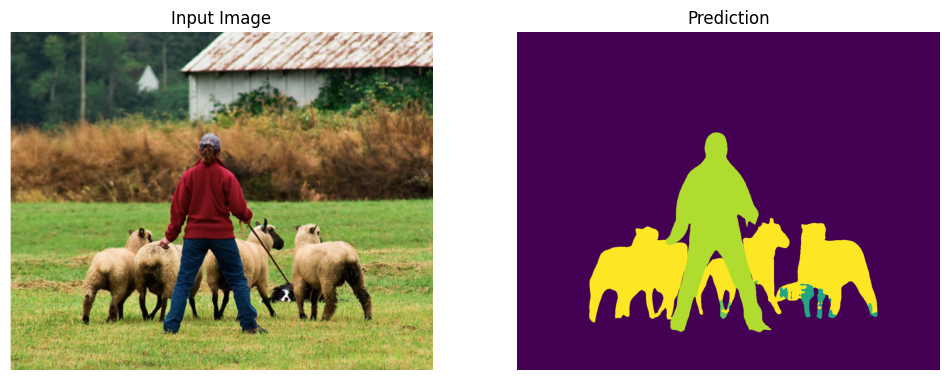

In [4]:
model.eval()
# Download example image (or replace with your own)
image_url = "https://github.com/pytorch/hub/raw/master/images/deeplab1.png"
image_path = "example_image.jpg"
torch.hub.download_url_to_file(image_url, image_path)

# Preprocess, predict, visualize
input_batch, input_image = preprocess(image_path)
prediction = predict(model, input_batch.to(device))
visualize(input_image, prediction.cpu().numpy(), "Input Image", "Prediction")

In [5]:
!git clone https://github.com/romiebanerjee/laplace.git
%cd laplace
from kfac.kfac import KFAC

Cloning into 'laplace'...
remote: Enumerating objects: 71, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 71 (delta 27), reused 52 (delta 14), pack-reused 0 (from 0)
Receiving objects: 100% (71/71), 905.40 KiB | 4.84 MiB/s, done.
Resolving deltas: 100% (27/27), done.
/content/laplace


In [6]:
mykfac = KFAC(model.to(device), device=device)

In [7]:

def random_pdsm(size, device):
    """Generate a random positive definite symmetric matrix"""
    # Empirical covariance of randomly sampled vectors
    n_samples = 100
    grads = torch.randn(n_samples, size, device = device)
    A = (grads -grads.mean(dim=0)).T @ (grads - grads.mean(dim=0))
    return A


def random_fisher(model):
  rand_fisher = dict()
  for name, module in model.named_modules():
    if module.__class__.__name__ in ['Conv2d']:
      c_out, c_in, h, w = module.weight.shape
      # print(f'out: {c_out}, in: {c_in}, h: {h}, w: {w}')
      q_size = c_in*h*w
      h_size = c_out
      Q = random_pdsm(q_size, device)
      H = random_pdsm(h_size, device)
      rand_fisher[name] =  [Q,H]
  return rand_fisher

mykfac.fisher = random_fisher(model)

In [8]:
# mykfac.kf_eigens()
# mykfac.invert_cholesky()
# mykfac.invert_fisher()

# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

# torch.save(mykfac.fisher, '/content/drive/MyDrive/models/fcresnet50_fisher.pt')
# torch.save(mykfac.invchol, '/content/drive/MyDrive/models/fcresnet50_invchol.pt')
# torch.save(mykfac.invfisher, '/content/drive/MyDrive/models/fcresnet50_invfisher.pt')

In [9]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# mykfac.fisher = torch.load('/content/drive/MyDrive/models/fcresnet50_fisher.pt', map_location= device)
# mykfac.invchol = torch.load('/content/drive/MyDrive/models/fcresnet50_invchol.pt', map_location= device)
mykfac.invfisher = torch.load('/content/drive/MyDrive/models/fcresnet50_invfisher.pt', map_location = device)

Mounted at /content/drive


In [10]:
#MC-GLM uncertainties
# import matplotlib.pyplot as plt
# from tqdm import tqdm

# logits = mykfac.model(input_batch.to(device))['out'][0] #logits (21, h, w)

# eps = 1e-6 #for numerical differentiation
# mc_preds = []
# iters = 12 #number of monte-carlo samples
# with torch.no_grad():
#     for i in tqdm(range(iters)):
#         mykfac.sample_and_replace(eps = eps)
#         output_logits_mc = mykfac.model(input_batch.to(device))['out'][0]
#         mc_preds.append(output_logits_mc)

# mykfac.model.load_state_dict(mykfac.model_state) #restore original weights
# mc_output_stacked = torch.stack(mc_preds) # shape: (iters, 21, h, w)

# A = (mc_output_stacked - logits)/eps #shape: (iters, 21, h, w)

# B = torch.matmul(A.permute(2,3,1,0), A.permute(2,3,0,1)) #shape: (h, w, n_classes, n_classes)
# final = torch.sum(torch.diagonal(B, dim1=-2, dim2=-1), dim = -1)

In [11]:
# visualize(logits.argmax(dim=0).detach().cpu().numpy(), final.detach().cpu().numpy(), "Original prediction", "mcglm uncertainties")

In [39]:
a = torch.randn(1 , 21, 1026, 1282)
ker = torch.nn.AvgPool2d(100, stride = (100, 100))
torch.reshape(torch.sum(ker(a), dim = 1), (-1,)).shape

torch.Size([120])

In [23]:
def kf_inner(grad_1: dict,
             grad_2: dict,
             inverse_fisher: dict) -> float:
    r'''
    inner product of gradients in KF form, w.r.t. inverse fisher metric

    The inner product <x,y>_A, w.r.t a symmetric bilinear form A, is the matrix product x^T@A@y

    For every layer `name` compute: grad_1[name].t @ inverse_fisher[name] @ grad_2[name]
    Use the kronecker factorization
    grad_1[name] = (q_1, h_1)
    grad_2[name] = (q_2, h_2)
    inverse_fisher[name] = (Q^{-1}, H^{-1})

    (q_1\otimes h_1)^T @ (Q^{-1}, H^{-1}) @ (q_2\otimes h_2)
    = (q_1^T @ Q^{-1} @ q_2) \otimes (h_1^T @ H^{-1} @ h_2)
    '''

    # assert len(grad_1) == len(grad_2) == len(inverse_fisher), "gradient and inverse fisher dimension mismatch"

    n = len(inverse_fisher)

    layer_inner_products = torch.empty(len(grad_1))

    for idx , (key, value) in enumerate(inverse_fisher.items()):

        if key in grad_1.keys() and key in grad_2.keys():
          forward_1, backward_1 = grad_1[key]
          forward_2, backward_2 = grad_2[key]
          Q_inv, H_inv = value

          try:
              if ((forward_1.shape[1] == Q_inv.shape[0]) and (Q_inv.shape[1] == forward_2.shape[0]) and (forward_1.shape[1] == H_inv.shape[0]) and (H_inv.shape[1] == backward_2.shape[0])):

                q = forward_1.t() @ Q_inv @ forward_2
                h = backward_1.t() @ H_inv @ backward_2

                layer_inner_products[idx] = q*h

          except Exception as error:
              print(f"Error in layer [{idx}]/[{n}]")
              print(error)

    return torch.sum(layer_inner_products)

In [18]:
from logging import log
import copy

logits = mykfac.model(input_batch.to(device))['out'][0] #logits (21, h, w)
ker = torch.nn.AvgPool2d(100, stride = 100)
logits_pooled_vec = torch.reshape(torch.sum(ker(logits), dim = 1), (-1,))

print(logits.shape)
print(logits_pooled_vec.shape)

output_size = logits_pooled_vec.shape

gradients = []
#compute gradient for every scalar outout (#via one backprop for every dimension in the output logit space)
for i in tqdm(range(output_size[0])):
    out = logits_pooled_vec[i]
    mykfac.model.zero_grad()
    out.backward(retain_graph=True)
    mykfac.update_grad(log = False)
    gradients.append(copy.deepcopy(mykfac.grad))




/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


torch.Size([21, 1026, 1282])
torch.Size([252])


100%|██████████| 252/252 [1:13:16<00:00, 17.45s/it]


AssertionError: gradient and inverse fisher dimension mismatch

In [36]:
vars = []
for grad in gradients:

  var = kf_inner(grad, grad, mykfac.invfisher)
  vars.append(var)

unc = torch.stack(vars)

In [37]:
unc_grid = torch.reshape(unc , torch.sum(ker(logits), dim = 1).shape)

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:2293: RuntimeWarning: overflow encountered in subtract
  resdat -= vmin


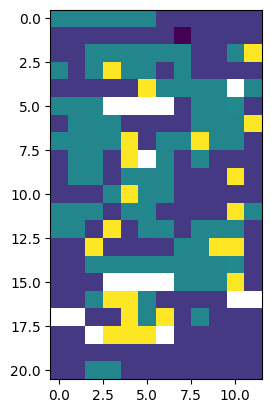

In [38]:
plt.imshow(unc_grid)